In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from models import NDS2SAEFactory


In [2]:
max_seq_len = 40
min_seq_len = 20

n_inputs = 2
n_neurons = 100
n_outputs = 1

len_x = 1000
x = np.linspace(0, 150, len_x)
total_start_points = len_x - max_seq_len

pad_token = 0

def generate_samples(time):
    x1 = 2 * np.sin(time)
    x2 = 2 * np.cos(time)
    return x1, x2


def generate_train_samples(batch_size=10):
    start_time_idx = np.random.choice(range(total_start_points), batch_size)
    sequence_lens = np.random.choice(range(min_seq_len, max_seq_len + 1), batch_size).astype(np.int32)

    time_axis = [x[t:(t + seq_len)] for t, seq_len in zip(start_time_idx, sequence_lens)]
    input = []
    output = []
    for t in time_axis:
        sin, cos = generate_samples(t)
        input.append(np.array([sin, cos]).transpose(1, 0))
        output.append(np.array([sin + cos]).transpose(1, 0))

    return input, output

def adjust_length(seqs, lens):
    for seg, len in zip(seqs, lens):
        seg[len:] = 0

In [3]:
factory = NDS2SAEFactory()
factory.input_dim = n_inputs
factory.output_dim = n_outputs
factory.layer_sizes = [50, 30]
encoder = factory.build('toy.zip')

# If toy.zip exists, the encoder will continue the training
# Otherwise it'll train a new model and save to toy.zip every {display_step}
encoder.train(generate_train_samples, generate_train_samples, n_iterations=3000, batch_size=100, display_step=100)

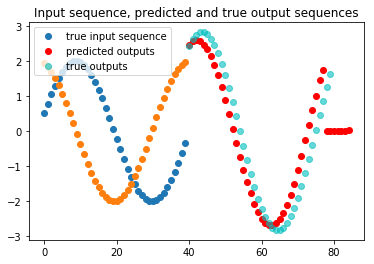

In [4]:
def show_test():
    test_seq, test_res = generate_train_samples(batch_size=50)
    predicted = encoder.predict(test_seq)

    seq_len = len(test_seq[0])
    pre_len = len(predicted[0])

    # adjust_length(predicted, test_seq_len)

    plt.title("Input sequence, predicted and true output sequences")
    i = plt.plot(range(seq_len), test_seq[0], 'o', label='true input sequence')
    p = plt.plot(range(seq_len, seq_len + pre_len), predicted[0], 'ro', label='predicted outputs')
    t = plt.plot(range(seq_len, seq_len + seq_len), test_res[0], 'co', alpha=0.6, label='true outputs')
    plt.legend(handles=[i[0], p[0], t[0]], loc='upper left')
    plt.show()

# Run this to use the trained autoencoder to encode and decode a randomly generated sequence
# And display them
show_test()

In [5]:
def run_encode():
    test_seq, test_res = generate_train_samples(batch_size=1)
    encoded = encoder.encode(test_seq)
    print(encoded)
# This will print out the encoded (hidden layers) value
run_encode()

encoder.cleanup()

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.66774610e-05 0.00000000e+00 2.33840084e+00
 0.00000000e+00 7.93216976e-33 0.00000000e+00 0.00000000e+00
 6.54585600e-01 1.81783092e+00 1.01573000e-36 0.00000000e+00
 0.00000000e+00 9.05538845e+00 0.00000000e+00 5.62529743e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.11060806e-01
 1.06096186e-01 2.91444004e-01 1.57644391e+00 5.69520354e-01
 4.42318404e-12 4.52767641e-12 8.50020206e-06 4.06485379e-09
 2.14240760e-01 1.39528885e-02 1.39240883e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.85810095e-02 1.01585472e+00
 0.00000000e+00 7.10201040e-02 1.15083995e-12 6.76961914e-02
 0.00000000e+00 2.81712913e-13 4.39558285e-21 2.91763786e-02
 0.00000000e+00 3.23557183e-02 5.22730798e-02 1.80801116e-02
 2.49322295e-01 7.95411303e-21 6.86369958e-06 0.00000000e+00
 8.83600587e-05 4.684009